Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = "NONE"

# Molecular Dynamics

[Molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics) (MD)is a simulation technique that is applied from actual molecules to systems as large as planetary rings (for granular systems and beyond it is known as [Discrete Element Method](https://en.wikipedia.org/wiki/Discrete_element_method)). The key is to have discrete bodies that interact under some given potential fields or forces and from that to integrate the equations of motion. To apply a MD simulation you will need to
- **define a body**: Usually done using a class/struct. Examples are atoms, molecules, grains of sand, rocks, blocks of ice, etc.
- **define forces among bodies**: Those can be only external (gravity, potential fields), or by contact (repulsion, friction, damping),  etc. Usually modeled using a Collider class/struct or similar.  
- **define an integration technique**: this will allow to solve the dynamic equations. Examples are Verlet, Velocity Verlet, Leap-Frog, Symplectic algorithms, RESPA, etc. Can be modeled as simple functions or as class/struct for more complex situations.

Of course many details are left out in this short introduction (pre-processing or sample preparation, optimization with [Verlet lists](https://en.wikipedia.org/wiki/Verlet_list) and/or [cell lists](https://en.wikipedia.org/wiki/Cell_lists), rotations, compund bodies, post-processing and analysis, etc). 

Some examples of HPC systems for Molecular Dynamics at the level of molecules are [lammps](https://www.lammps.org/#gsc.tab=0), [grommacs](https://www.gromacs.org/), and [many more](https://en.wikipedia.org/wiki/Comparison_of_software_for_molecular_mechanics_modeling). For the Discrete Element Method, we have [lammps](https://www.lammps.org/#gsc.tab=0) (with the granular package), [liggghts](https://www.cfdem.com/liggghtsr-open-source-discrete-element-method-particle-simulation-code), [mechsys](https://mechsys.nongnu.org/), [mercury dpm](https://www.mercurydpm.org/), [Yade](https://yade-dem.org/wiki/Yade), [Altair](https://www.altair.com/edem), [Rocky](https://rocky.esss.co/), etc

In the following we will focus MD applied to macroscopic bodies (in the final projects you will be able to use some of the previously mentioned packages and to apply it to different systems).


# Defining the body
We will start by simulating a particle under the gravity force. The basic attributes to for a particle of this kind would be
- mass (scalar)
- Position, velocity and force (vectors)
Other possible like the radius are not as relevant now since we are focusing only on Center of Mass dynamics. Let's define the body class 

In [2]:
import numpy as np
class Body:
    """
    Class to model a simple point body
    """
    def __init__(self, R0, V0, m0): # constructor
        self.mass = m0
        self.R = np.array(R0)
        self.V = np.array(V0)
        self.F = np.zeros(3)

To use it, let's just instantiate the class

In [3]:
R0 = np.array([0, 0.9, 0.0])
V0 = np.array([0.98, 1.23, 0.0])
mass = 0.4343
body = Body(R0, V0, mass)

# Forces 
For now, we will just add gravity, so our `Collider` class will be very simple, with only some parameters

In [4]:
class Collider:
    """
    Class to compute forces on each body
    """
    # Parameters
    G = np.array([0.0, -9.81, 0.0])
    
    # Functions
    def computeForce(self, body): # For now operate on a single body
        body.F = np.zeros(3) # Reset the force
        body.F += body.mass*self.G # Add gravity

# Integration algorithm
Here we will need to define the algorithm that will advance the system forward in time. There are several possibilities, like using the Euler algorithm (unstable), Runge-Kutta (not advisable since it evaluates the force 4 times per integration step), or better something like [Verlet](https://en.wikipedia.org/wiki/Verlet_integration), Optimized Verlet, [Leap-Frog](https://en.wikipedia.org/wiki/Leapfrog_integration), etc. Here, we will use the leap-frog algorithm.

## Leap-frog algorithm
First, let's expand the position around $t + \delta t$, 

$$\vec R(t + \delta t) = \vec R(t) + \delta t \vec V(t) + \delta t^2 \vec A(t)/2 + O(\delta t^3), $$

but, from the previous, one can expand around $t + \delta t/2$ as

$$\vec R(t + \delta t) = \vec R(t + \delta t/2 + \delta t/2) = \vec R(t + \delta t/2) + \delta t \vec V(t + \delta t/2)/2 + (\delta t/2)^2 \vec A(t + \delta t/2)/2 + O(\delta t^3). $$

Also, 

$$\vec R(t) = \vec R(t + \delta t/2 - \delta t/2) = \vec R(t + \delta t/2) - \delta t \vec V(t + \delta t/2)/2 + (\delta t/2)^2 \vec A(t + \delta t/2)/2 + O(\delta t^3). $$

Finally, by substrating the last two equation and re-grouping,

$$\vec R(t + \delta t) = \vec R(t) + \delta t \vec V(t + \delta t/2) + O(\delta t^3), $$
$$\vec V(t + \delta t/2) = \vec V(t - \delta t/2) + \delta t \vec A(t) + O(\delta t^3). $$

This are the expression for the Leap-Frog method. As you can see, you need first to compute $V(t + \delta t/2)$ to later computer $R(t + \delta t)$. This algorithm, given the positions, velocities and Forces (accelerations) at time $t$, allows you to compute the next position and velocities at time-step $t+\delta t$ and $t + \delta t/2$, respectively.

---
**NOTE**: What happens when moving from $t = 0$ to $t = 0 + \delta t$ (first time step)?. At the beginning of the simulation, you have $\vec R(0)$, $\vec V(0)$ and $\vec A(0)$. But, for the first time step, the Leap-Frog equations give

$$\vec V(0 + \delta t/2) = \vec V(0 - \delta t/2) + \delta t \vec A(0),$$
$$\vec R(0 + \delta t) = \vec R(0) + \delta t \vec V(0 + \delta t/2).$$

So you need the velocity at time $t = -\delta t/2$, not at time $t = 0$. This implies that the method is not "self-started", and you need first to change the velocity from its initial value to

$$\vec V(-\delta t/2) = \vec V(0) - \delta t\vec A(0)/2.$$


In [5]:
class TimeIntegrator:
    """
    Class that uses Leapfrog to advance in time
    """
    dt = 0.01 # should be changed according to the simulation needs
    def __init__(self, dt): # constructor
        self.dt = dt
        
    def startIntegration(self, body):
        body.V = body.V - 0.5*self.dt*body.F/body.mass
        
    def timestep(self, body):
        body.V = body.V + self.dt*body.F/body.mass
        body.R = body.R + self.dt*body.V
        

## Particle falling under constant gravity
Now we are ready to perform our first simple simulation of a particle under the action of constant gravity.

In [6]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing: Setup. For more particless: mass distribution, random positions, etc
particle = Body([1.23, 2.34, 0.0], [0.0, 0.0, 0.0], 0.654)

# Collider
collider = Collider()
collider.computeForce(particle) # Initial force

# Time evolution stuff
DT = 0.05
T = np.arange(0.0, 2.5, DT)
NSTEPS = T.size
leapfrog = TimeIntegrator(DT)
leapfrog.startIntegration(particle)

# Save data
Ry = np.zeros(NSTEPS); 
Vy = np.zeros(NSTEPS)

# main evolution loop
it = 0
while it < NSTEPS:
    Ry[it] = particle.R[1]; Vy[it] = particle.V[1]
    collider.computeForce(particle)
    leapfrog.timestep(particle)
    it = it + 1

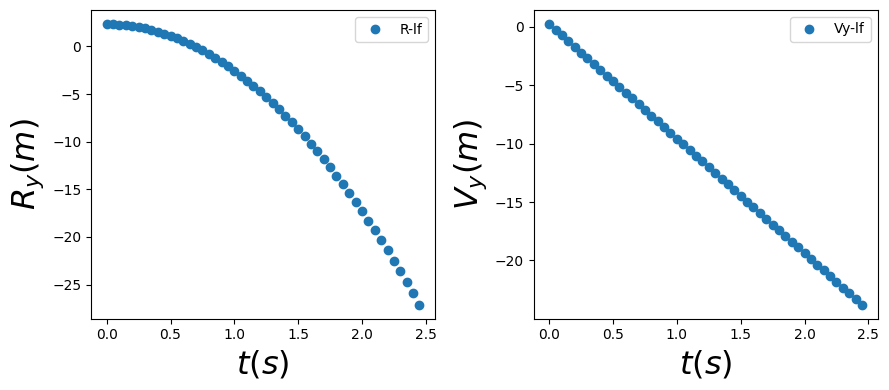

In [7]:
# plot final trayectories 
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(T, Ry, 'o', label="R-lf")
#ax[0].plot(T, R0[1] + V0[1]*T + 0.5*T*T*G[1], '-', label="Exact", lw=3)
ax[1].plot(T, Vy, 'o', label="Vy-lf")
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel(r"$t(s)$", fontsize=23)
ax[0].set_ylabel(r"$R_y(m)$", fontsize=23)
ax[1].set_xlabel(r"$t(s)$", fontsize=23)
ax[1].set_ylabel(r"$V_y(m)$", fontsize=23)
plt.tight_layout()

<ipython-input-8-71db86a24407>:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(T[i], Ry[i])


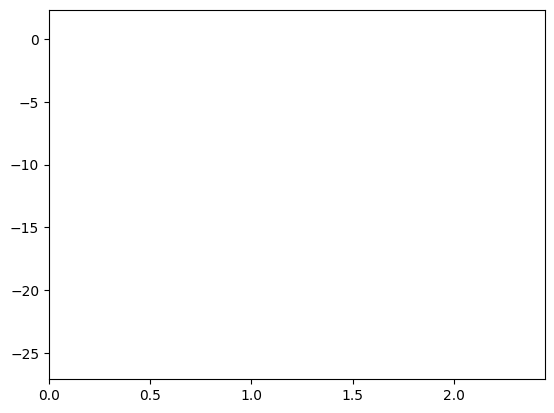

In [8]:
# Animation
import matplotlib.animation as animation
fig, ax = plt.subplots()
ax.set_xlim([0, T[-1]])
ax.set_ylim([Ry.min(), Ry.max()])
line, = ax.plot([], [],'o')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(T[i], Ry[i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=NSTEPS, interval=20, blit=False)
anim.save('ParticleGravity.mp4', fps=30)

# Exercise: damping and bouncing 
Modify the collider to add some damping with the air (a force with the form $-bm\vec v$, with $v$ the speed). Also, add a force with the ground, of the form $k\delta \hat n$, with $\delta$ the interpenetration and $\hat n$ is the normal to the plane. Assume the body is now a sphere (it has a radius `radius`)

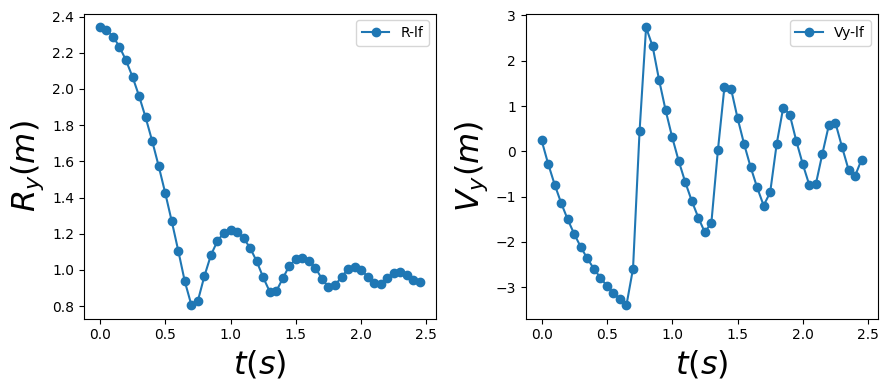

In [9]:
import numpy as np
class Body:
    """
    Class to model a simple point body
    """
    def __init__(self, R0, V0, m0): # constructor
        self.mass = m0
        self.radius = 0.0
        self.R = R0
        self.V = V0
        self.F = np.zeros(3)

class Collider:
    """
    Class to compute forces on each body
    """
    # Parameters
    G = np.array([0.0, -9.81, 0.0])
    B = 2.245
    k = 234.65
    # K = np.array([,,])#Vector de onda?

    # Functions
    def computeForce(self, body): # For now operate on a single body
        body.F = np.zeros(3) # Reset the force
        body.F += body.mass*self.G # Add gravity
        body.F -= self.B*body.mass*body.V # Add damping force

        # add force with ground
        delta = body.radius - body.R[1] # R-y
        if delta > 0:
            #Add gravity and Hooke Force
            body.F[1] +=  self.k*delta #+ body.mass*self.G  
        
        
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing: Setup. For more particless: mass distribution, random positions, etc
particle = Body(np.array([1.23, 2.34, 0.0]), np.array([0.0, 0.0, 0.0]), 0.654)
particle.radius = 0.987

# Collider
collider = Collider()
collider.computeForce(particle) # Initial force

# Time evolution stuff
DT = 0.05
T = np.arange(0.0, 2.5, DT)
NSTEPS = T.size
leapfrog = TimeIntegrator(DT)
leapfrog.startIntegration(particle)

# Save data
Ry = np.zeros(NSTEPS); 
Vy = np.zeros(NSTEPS)

# main evolution loop
it = 0
while it < NSTEPS:
    Ry[it] = particle.R[1]; Vy[it] = particle.V[1]
    collider.computeForce(particle)
    leapfrog.timestep(particle)
    it = it + 1
    
# plot final path
fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(T, Ry, '-o', label="R-lf")
ax[1].plot(T, Vy, '-o', label="Vy-lf")
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel(r"$t(s)$", fontsize=23)
ax[0].set_ylabel(r"$R_y(m)$", fontsize=23)
ax[1].set_xlabel(r"$t(s)$", fontsize=23)
ax[1].set_ylabel(r"$V_y(m)$", fontsize=23)
plt.tight_layout()

<ipython-input-10-f1dbfd18a66e>:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(T[i], Ry[i])


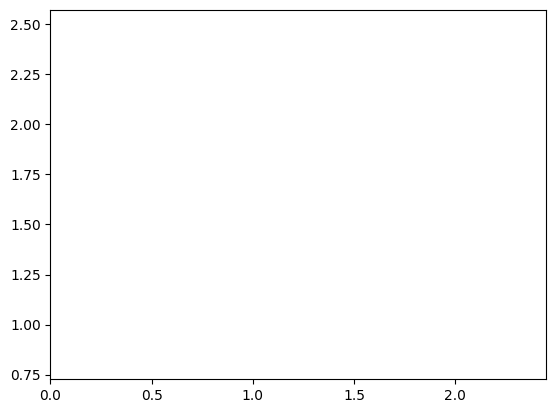

In [10]:
# Animation
import matplotlib.animation as animation
fig, ax = plt.subplots()
ax.set_xlim([0, T[-1]])
ax.set_ylim([0.9*Ry.min(), 1.1*Ry.max()])
line, = ax.plot([], [],'o')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(T[i], Ry[i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=NSTEPS, interval=20, blit=False)
anim.save('ParticleBouncing.mp4', fps=30)

# Exercise: Bouncing with left and right walls
Now implement both left and right walls. Decrease a bit the damping so you can see the actual bouncing. Plot now $R_y$ versus $R_x$. The right wall position is at $L_x/2$, the left wall at $-L_x/2$.

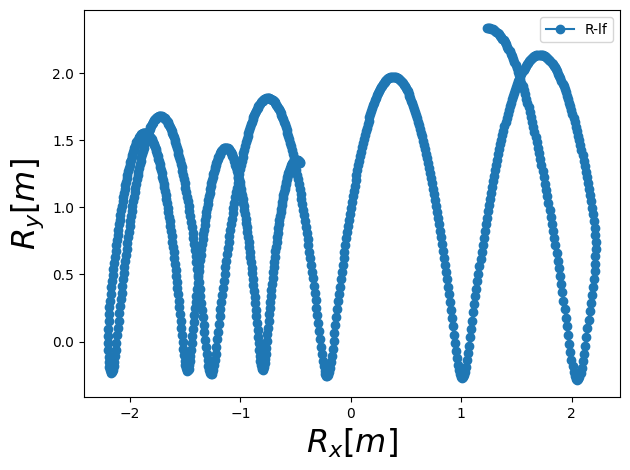

In [11]:
class Collider:
    """
    Class to compute forces on each body
    """
    # Parameters
    G = np.array([0.0, -9.81, 0.0])
    B = 0.085
    K = 234.65
    LX = 4.5 # Right wall position
    
    # Functions
    def computeForce(self, body): # For now operate on a single body
        body.F = np.zeros(3) # Reset the force
        body.F += body.mass*self.G # Add gravity
        body.F -= self.B*body.mass*body.V # Add damping force
        
        # add force with ground
        deltay = body.radius - body.R[1] # R-y
        if deltay > 0:
            #Add gravity and Hooke Force
            body.F[1] +=  self.K*deltay #+ body.mass*self.G  
        

        # add force with the right wall
        deltax = body.radius + body.R[0] - self.LX/2 # R + x - Lx/2
        if deltax > 0:
            #Add gravity and Hooke Force
            body.F[0] -=  self.K*deltax #+ body.mass*self.G  


        # add force with the left wall
        deltax = body.radius - body.R[0] - self.LX/2 # R - x - Lx/2
        if deltax > 0:
            #Add gravity and Hooke Force
            body.F[0] +=  self.K*deltax #+ body.mass*self.G  



   

        
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing: Setup. For more particless: mass distribution, random positions, etc
particle = Body(np.array([1.23, 2.34, 0.0]), np.array([1.1, 0.0, 0.0]), 0.654)
particle.radius = 0.087

# Collider
collider = Collider()
collider.computeForce(particle) # Initial force

# Time evolution stuff
DT = 0.01
T = np.arange(0.0, 9.5, DT)
NSTEPS = T.size
leapfrog = TimeIntegrator(DT)
leapfrog.startIntegration(particle)

# Save data
Rx = np.zeros(NSTEPS); 
Ry = np.zeros(NSTEPS); 
Vy = np.zeros(NSTEPS)

# main evolution loop
it = 0
while it < NSTEPS:
    Rx[it] = particle.R[0]; Ry[it] = particle.R[1]; Vy[it] = particle.V[1]
    collider.computeForce(particle)
    leapfrog.timestep(particle)
    it = it + 1
    
# plot final path
fig, ax = plt.subplots()
ax.plot(Rx, Ry, '-o', label="R-lf")
ax.legend()
ax.set_xlabel(r"$R_x [m]$", fontsize=23)
ax.set_ylabel(r"$R_y [m]$", fontsize=23)
plt.tight_layout()

<ipython-input-12-b26a02beb0d7>:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(Rx[i], Ry[i])


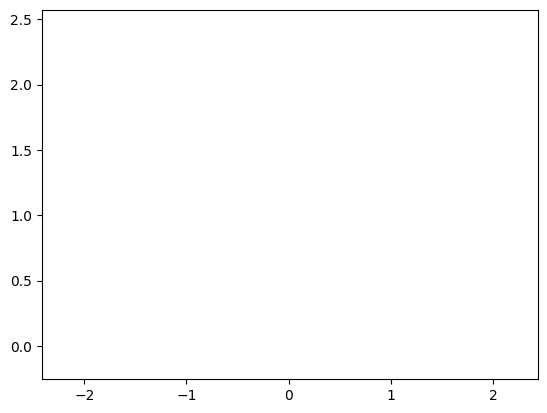

In [12]:
# Animation
import matplotlib.animation as animation
fig, ax = plt.subplots()
ax.set_xlim([1.1*Rx.min(), 1.1*Rx.max()])
ax.set_ylim([0.9*Ry.min(), 1.1*Ry.max()])
line, = ax.plot([], [],'o')

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(Rx[i], Ry[i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=NSTEPS, interval=20, blit=False)
anim.save('ParticleBouncing-LRBwalls.mp4', fps=30)

# Exercise: Adding more particles
Now let's add more particles. They will not see each other unless we implement a force among them. Also, we will need to generalize our methods to process arrays of bodies. First, the force that particle $i$ does on particle $j$ is given by
\begin{equation}
\vec F_{ij} = k \delta \hat n_{ij},
\end{equation}
where $\hat n_{ij} = \vec R_{ij} / R_{ij}$, with $\vec R_{ij} = \vec R_i - \vec R_j$, and $\delta = r_i + r_j - R_{ij}$, with $r$ the radius of each particle.

If the $\delta$ is with respect to the contact plane, the $\delta$ will be $\delta/2$. The contact plane is defined as the plane passing through the intersection surface of the two spheres describing each particle.

In [13]:
import numpy as np

class TimeIntegrator:
    """
    Class that uses Leapfrog to advance in time
    """
    dt = 0.01 # should be changed according to the simulation needs
    def __init__(self, dt): # constructor
        self.dt = dt
        
    def startIntegration(self, bodies):
        for body in bodies:
            body.V = body.V - 0.5*self.dt*body.F/body.mass
        
    def timestep(self, bodies):
        for body in bodies:
            body.V = body.V + self.dt*body.F/body.mass
            body.R = body.R + self.dt*body.V


class Collider:
    """
    Class to compute forces on each body
    """
    # Parameters
    G = np.array([0.0, -9.81, 0.0])
    B = 0.085
    K = 234.65
    LX = 4.5 # Right wall position
    
    # Functions
    def computeForce(self, bodies):

        for body in bodies: # Individual forces
            body.F = np.zeros(3) # Reset the force
            body.F += body.mass*self.G # Add gravity
            
            # add force with ground
        deltay = body.radius - body.R[1] # R-y
        if deltay > 0:
            #Add gravity and Hooke Force
            body.F[1] +=  self.K*deltay #+ body.mass*self.G  
        

        # add force with the right wall
        deltax = body.radius + body.R[0] - self.LX/2 # R + x - Lx/2
        if deltax > 0:
            #Add gravity and Hooke Force
            body.F[0] -=  self.K*deltax #+ body.mass*self.G  


        # add force with the left wall
        deltax = body.radius - body.R[0] - self.LX/2 # R - x - Lx/2
        if deltax > 0:
            #Add gravity and Hooke Force
            body.F[0] +=  self.K*deltax #+ body.mass*self.G  



        # Add body-body interactions. Use third Newton law
        for i in range(len(bodies)):
            for j in range(i+1,len(bodies)):
                Rij = bodi
        
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing: Setup. For more particless: mass distribution, random positions, etc
particle1 = Body(np.array([1.23, 2.34, 0.0]), np.array([1.1, 0.0, 0.0]), 0.654)
particle1.radius = 0.087
particle2 = Body(np.array([-1.23, 2.34, 0.0]), np.array([-1.1, 0.0, 0.0]), 0.654)
particle2.radius = 0.087
particles = np.array([particle1, particle2])

# Collider
collider = Collider()
collider.computeForce(particles) # Initial force

# Time evolution stuff
DT = 0.01
T = np.arange(0.0, 9.5, DT)
NSTEPS = T.size
leapfrog = TimeIntegrator(DT)
leapfrog.startIntegration(particles)

# Save data
Rx0 = np.zeros(NSTEPS); 
Ry0 = np.zeros(NSTEPS); 
Rx1 = np.zeros(NSTEPS); 
Ry1 = np.zeros(NSTEPS); 
Vx0 = np.zeros(NSTEPS); 
Vy0 = np.zeros(NSTEPS); 
Vx1 = np.zeros(NSTEPS); 
Vy1 = np.zeros(NSTEPS); 

# main evolution loop
it = 0
while it < NSTEPS:
    Rx0[it] = particles[0].R[0]; Ry0[it] = particles[0].R[1]; 
    Rx1[it] = particles[1].R[0]; Ry1[it] = particles[1].R[1]; 
    Vx0[it] = particles[0].V[0]; Vy0[it] = particles[0].V[1]; 
    Vx1[it] = particles[1].V[0]; Vy1[it] = particles[1].V[1]; 
    collider.computeForce(particles)
    leapfrog.timestep(particles)
    it = it + 1
    
# plot final path
fig, ax = plt.subplots()
ax.plot(Rx0, Ry0, '-o', label="Particle 0")
ax.plot(Rx1, Ry1, '-o', label="Particle 1")
ax.legend()
ax.set_xlabel(r"$R_x [m]$", fontsize=23)
ax.set_ylabel(r"$R_y [m]$", fontsize=23)
plt.tight_layout()

fig, ax = plt.subplots()
ax.plot(T, Vx0, '-o', label="Particle 0")
ax.plot(T, Vx1, '-o', label="Particle 1")
ax.legend()
ax.set_xlabel(r"$R_x [m]$", fontsize=23)
ax.set_ylabel(r"$R_y [m]$", fontsize=23)
plt.tight_layout()

NameError: ignored

In [ ]:
# For printing vtk data: Run this here or remove the ! and run it in the console
!conda install -y -c conda-forge pyevtk

In [ ]:
# Printing data for paraview visualization. DISPLAY Folder must exist
from pyevtk.hl import pointsToVTK
for ii in range(len(T)):
    pointsToVTK(f"./DISPLAY/system_{ii}", 
                np.array([Rx0[ii], Rx1[ii]]), 
                np.array([Ry0[ii], Ry1[ii]]), 
                np.array([0.0, 0.0]), 
                data={"radius": np.array([0.087, 0.087]), 
                      "speed": np.array([np.linalg.norm([Vx0[ii], Vy0[ii]]), 
                                         np.linalg.norm([Vx1[ii], Vy1[ii]])])})

# Exercise: Two planets
Implement the gravitational attraction between two bodies, like the earth and the moon, and simulate their orbits.